#6.1 CNN

# 6.1 From Fully-Connected Layers to Convolutions

1 메가 픽셀의 사진에서 데이터 수집을 진행할 때, fully connected layer로 학습을 한다면 각 input 마다 백만개의 dimension을 가지게 된다는 것을 의미하며, 이는 GPU 등의 성능으로 커버가 불가능하다.

따라서 이를 극복하기 위한 방법을 제시하였다.

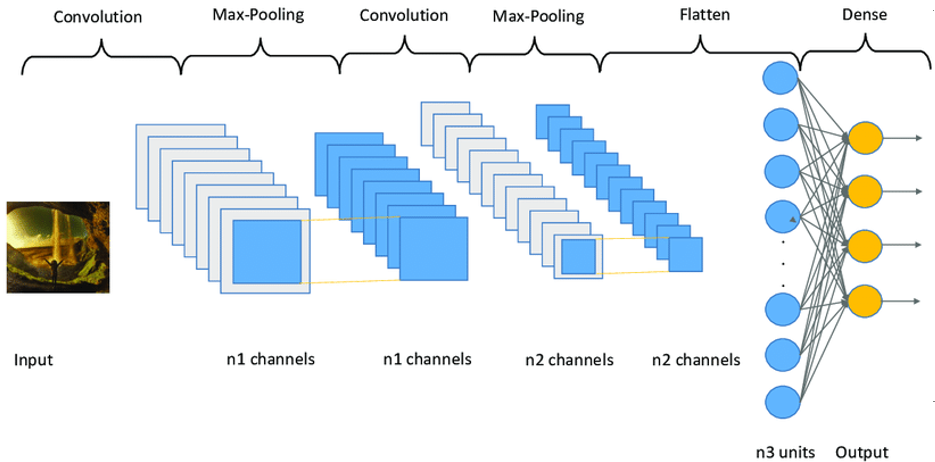

Image를 학습하는 과정에서 convolution을 진행할 때 첫번째 layer에서 다음 두 가지 특성을 보존해야 한다.

1. Translational invariance: 입력 위치에 따라 출력이 바뀌지 않음

2. Locality: 근접한 픽셀 사이에 연관성이 있음

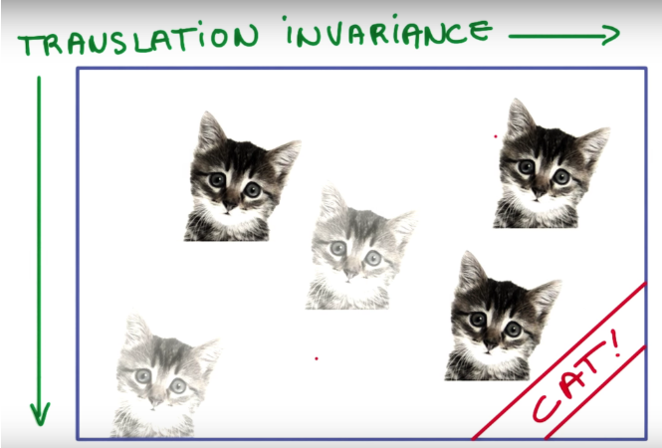

첫 번째 hidden layer를 fully-connected layer에서 처럼 weight와 bias 형식으로 입력해줄 수 있음.

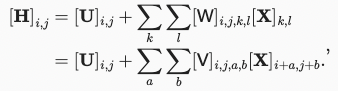

Input image X

Hidden layer H

Bias U

Weight W, V (딥러닝 시 V를 convolutional kernel, filter라고 말함)

Translational invariance를 위해 weight와 bias에서 입력 위치에 대한 정보를 제거하여 '상수화'함.

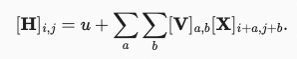

Locality를 위해 weight V가 작용하는 범위를 정해줌.

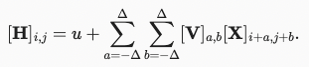

우리가 학습하고자 하는 이미지는 보통 컬러로 되어있고, 이는 2차원인 위치 정보 이외에 색이라는 새로운 차원이 추가되어야 한다는 의미임.

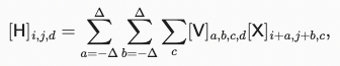

그러면 왜 이러한 과정을 convloution이라고 이름 붙였을까?

수학에서 두 함수를 convolution하는 수식은 다음과 같음.

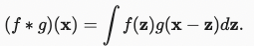

Discrete objects에서 integral은 summation으로 대치될 수 있고

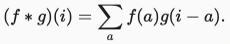

input 변수가 2차원 임을 고려하여 다음과 같이 나타낼 수 있음.

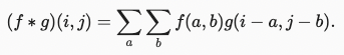

이는 위에서 보여준 구조와 상당히 유사함.

사실 CNN에서 이뤄지는 과정은 엄밀하게는 convolution이 아니고 cross correlation operation임.

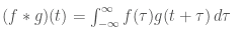

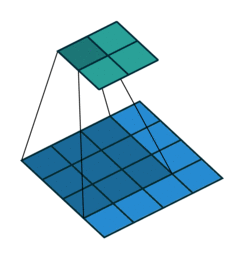

Convolution은 하나의 함수와 또 다른 함수를 반전 이동한 값을 곱한 다음, 구간에 대해 적분하여 새로운 함수를 구하는 수학 연산자임.

합성곱 신경망의 입력값에 필터(커널)를 convolution하려면 필터를 뒤집어서 적용해야 하는데 어차피 필터의 값을 학습하려는 것이 목적이기 때문에 뒤집어서 convolution을 하나, 그냥 하나 결과값은 똑같음. (학습, 추론 시 필터만 일정하게 설정해주면 됨)

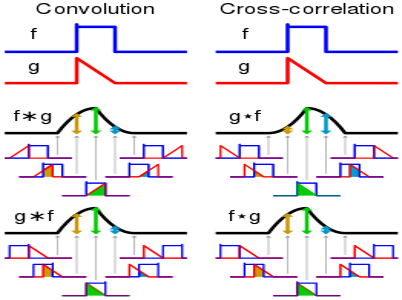

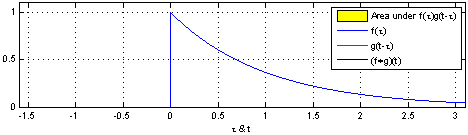

딥러닝 프레임워크에서는 cross correlation으로 구성되어 있으나 관습상 합성곱이라고 말함.

## 6.2.1 Cross-correlation operation

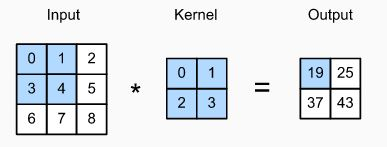

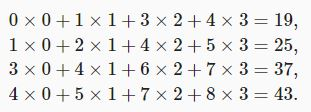

2차원 cross correlation operation은 위와 같이 이루어짐.

output size는 input size (nh, nw) 및 convolution kernel size (kh, kw)에 의해 결정됨.

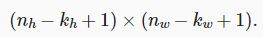

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K): 
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 6.2.2 Convolutional Layers

Convolutional layer에서 input과 kernel을 cross-correlation 연산한 뒤 scalar bias를 더해줌.

Fully-connected layer에서 진행했던 것처럼 kernel initialization을 진행함.

In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

init 함수에서 weight와 bias를 model parameter로 설정하고, 앞서 정의한 corr2d 함수를 연산하게 함.

## 6.2.3 Object Edge Detection in Images

객체의 가장자리를 감지하는 예시

6x8 픽셀의 흑백의 이미지를 구성하고

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

높이가 1, 너비가 2인 kernel K를 구성

수평의 픽셀값이 동일하면 0으로 출력됨.

In [ ]:
K = torch.tensor([[1.0, -1.0]])
K.shape

torch.Size([1, 2])

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

전치된 이미지에서는 가장자리를 확인하지 못함.

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

전치된 이미지에서는 높이 2, 너비 1인 kernel을 사용하면 됨.

In [ ]:
Kt = torch.tensor([[1.0],[-1.0]])

In [ ]:
corr2d(X.t(),Kt)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])

## 6.2.4 Learning a Kernel

input X로부터 생성된 Y가 주어졌을 때, kernel을 학습해보자.

계산의 편의성을 위해 bias는 무시하고, Y와 Y hat을 비교할 때 squared error를 활용.

In [ ]:
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 7.013
epoch 4, loss 1.878
epoch 6, loss 0.602
epoch 8, loss 0.219
epoch 10, loss 0.085


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9600, -1.0190]])

# 6.3 Padding and Stride

## 6.3.1 Padding

일반적으로 kernel size는 1보다 크기 때문에 여러번의 convolutional layer를 통과하면 output size가 input에 비해 상당히 작아지는 모습을 보임.

이를 극복하기 위해 padding을 활용함.

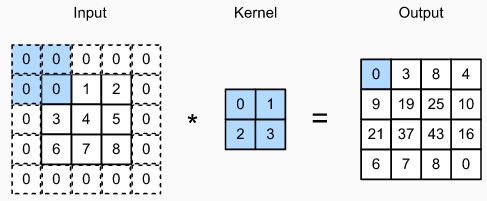

kernel을 거치면서 가장자리의 weight가 중요함에도 가장자리 부분은 적게 반영되는 경우가 있음.

Padding을 적용할 때 output size는 다음과 같음.

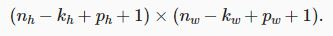

딥러닝 시 보통 kernel size를 홀수로 설정하는데, 이때 위아래에 동일한 수의 padding을 채워주면서 공간 차원을 보존할 수 있다는 이점이 있음.

In [ ]:
import torch
from torch import nn


# We define a convenience function to calculate the convolutional layer. This
# function initializes the convolutional layer weights and performs
# corresponding dimensionality elevations and reductions on the input and
# output
def comp_conv2d(conv2d, X):
    # Here (1, 1) indicates that the batch size and the number of channels
    # are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: examples and
    # channels
    return Y.reshape(Y.shape[2:])
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

Kernel size의 높이와 너비가 서로 다른 경우 padding size 역시 높이와 너비를 서로 다르게 설정하여 input, output size를 맞출 수 있음.

In [ ]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on either side of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 6.3.2 Stride

Stride를 통해 커다란 이미지를 작게 해줄 수 있음.

기본적으로 한픽셀씩 kernel이 이동하게 되는데, 이를 설정해줄 수 있음.

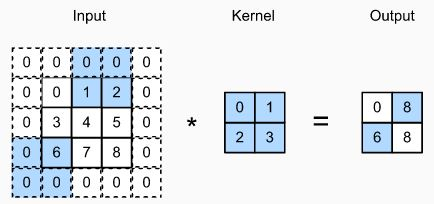

이 때 output size는 다음과 같이 계산해줄 수 있음.

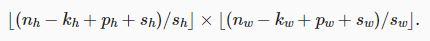

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

Stride에서도 padding에서처럼 너비와 높이를 다르게 설정해줄 수 있지만, 실제로 이렇게 사용하는 경우는 드물다.